In [61]:
import numpy as np
import pandas as pd
import scipy as sp
import os
import string
import glob
import re

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Wouter style preprocessing

In [62]:
files = glob.glob('../data/txt/*.txt')

In [63]:
# list of lists, so we can keep info about spelling variants in individual arrays

stops = []

with open('../data/functionwords_slim.txt','r') as file:
    for line in file:
        words = [x for x in line.lower().split() if x != '/']
        stops.append(words)
            
print(stops[:3])

[['aut', 'avt'], ['autem', 'avtem'], ['cum', 'cvm']]


In [64]:
folder_path = '../data/txt'

def preprocess_text(text):
    # lowercase
    text = text.lower()
    # remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    
    return text

def slice_text_into_samples(text, sample_size=1000):
    text = text.split()
    num_samples = len(text) // sample_size
    samples = [text[i * sample_size : (i + 1) * sample_size] for i in range(num_samples)]
    
    return samples

def preprocess_and_slice_text_files(folder_path, sample_size=1000):
    processed_texts = {}
    names = []
    translators = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"): # i'm skipping the Mysery files
            with open(os.path.join(folder_path, filename), "r", encoding='latin-1') as file:
                text = file.read()
                processed_text = preprocess_text(text)
                samples = slice_text_into_samples(processed_text, sample_size)
                num_samples = len(samples)
                for i, sample in enumerate(samples):
                    variable_name = filename[:-4] + "_" + str(i)
                    processed_texts[variable_name] = sample
            print(f"'{filename}' was processed and split into {num_samples} samples")
    return processed_texts

In [65]:
preprocess = preprocess_and_slice_text_files(folder_path)

'BurCom.txt' was processed and split into 24 samples
'AristPha.txt' was processed and split into 20 samples
'BurInt.txt' was processed and split into 64 samples
'AnonMetaph.txt' was processed and split into 61 samples
'BurEthN.txt' was processed and split into 4 samples
'BarMor.txt' was processed and split into 20 samples
'AristMet.txt' was processed and split into 6 samples
'BarMirab.txt' was processed and split into 7 samples
'WilMet.txt' was processed and split into 30 samples
'JamPhys.txt' was processed and split into 53 samples
'WilInPar.txt' was processed and split into 161 samples
'BarMun.txt' was processed and split into 5 samples
'WilTet.txt' was processed and split into 33 samples
'BarSig.txt' was processed and split into 3 samples
'AristPhaP.txt' was processed and split into 0 samples
'BarPri.txt' was processed and split into 2 samples
'WilInTim.txt' was processed and split into 4 samples
'JamMetaph.txt' was processed and split into 15 samples
'BurNemP.txt' was processed and

# 2. Chunk dataframe

In [66]:
entries = []
for k, txt in preprocess.items():
    # grab the part before the chunk number in the key, split into translator
    # and work. We need to drop empty strings that come from re.split.
    ww = [x for x in re.split('([A-Z][a-z]*)', k.split('_')[0]) if x]
    transl = ww[0]
    work = ''.join(ww[1:])
    chunk = ' '.join(txt)
    entries.append({
        'Translator' : transl,
        'Work' : work,
        'Chunk' : chunk
        })
chunk_df = pd.DataFrame(entries)
chunk_df

,Translator,Work,Chunk
0,Bur,Com,quoniam quidem ex calido et frigido et sicco e...
1,Bur,Com,sermo non quod nunquam fit in uno eodemque cor...
2,Bur,Com,horis anni invenire quartam coniugationem comp...
3,Bur,Com,quod necesse est in ea putrefieri omnia incipi...
4,Bur,Com,de ipsis per capitula quantum ad presentia uti...
...,...,...,...
1171,Bur,Fid,ostendat quod secundum veritatem est homo cum ...
1172,Bur,Fid,causative dicere ut hoc tibi soli peccavi et p...
1173,Bur,Fid,condemnavit peccatum in carne ut iustitia legi...
1174,Bur,Fid,uxorem suam et concepit et genuit quare propte...


In [67]:
set(chunk_df.Work)

{'1',
 '2',
 '3',
 '4',
 '5',
 'Alex',
 'Anim',
 'Cael',
 'Com',
 'Elem',
 'EthN',
 'EthV',
 'Fid',
 'Gen',
 'GenA',
 'His',
 'Hom',
 'InPar',
 'InTim',
 'Int',
 'Mat',
 'Men',
 'Met',
 'Metaph',
 'Mirab',
 'Mor',
 'Mun',
 'P',
 'Pha',
 'Phys',
 'Pri',
 'Pue',
 'Sig',
 'Simp',
 'Tet',
 'X'}

# 3. Vectorize, select only keyword freqs, merge spelling variants

In [68]:
vectorizer = TfidfVectorizer(use_idf=False, analyzer='word', decode_error='replace')
X = vectorizer.fit_transform(chunk_df.Chunk)


In [69]:
# There is some encoding horror happening here, but the Latin stops won't be affected (hopefully?!)

df = pd.DataFrame(X.toarray())
df.columns = vectorizer.get_feature_names_out()
df.head()

,10,12,13,130,14,15,16,1capite,20,23,...,î½îµá,î½îµî,î½îµîºîµî½î,î½îµï,î½î½á,î½ï,î¾á½,î¾îµî¹ï,î¾îµï,ügnotum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
flat_stops = [item for sublist in stops for item in sublist]

stops_df = df[df.columns.intersection(flat_stops)]

In [71]:
# Just our Pieter stopwords now, but not all of the (eg no 'atqvi')

stops_df

,aut,autem,avt,avtem,cum,cvm,eciam,enim,ergo,etiam,...,tanquam,uelut,uero,ut,utique,velut,velvt,vero,vt,vtiqve
0,0.034605,0.190328,0.0,0.0,0.051908,0.0,0.0,0.112467,0.000000,0.008651,...,0.0,0.0,0.0,0.051908,0.077862,0.008651,0.0,0.077862,0.0,0.0
1,0.079463,0.229559,0.0,0.0,0.061804,0.0,0.0,0.141267,0.017658,0.000000,...,0.0,0.0,0.0,0.088292,0.123609,0.008829,0.0,0.026488,0.0,0.0
2,0.091264,0.228161,0.0,0.0,0.000000,0.0,0.0,0.109517,0.000000,0.009126,...,0.0,0.0,0.0,0.100391,0.054759,0.018253,0.0,0.091264,0.0,0.0
3,0.114119,0.333577,0.0,0.0,0.017557,0.0,0.0,0.114119,0.000000,0.000000,...,0.0,0.0,0.0,0.131675,0.079005,0.000000,0.0,0.017557,0.0,0.0
4,0.371354,0.234115,0.0,0.0,0.040365,0.0,0.0,0.048438,0.000000,0.000000,...,0.0,0.0,0.0,0.226042,0.121094,0.000000,0.0,0.040365,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,0.008708,0.191573,0.0,0.0,0.060955,0.0,0.0,0.104494,0.000000,0.000000,...,0.0,0.0,0.0,0.208988,0.008708,0.000000,0.0,0.008708,0.0,0.0
1172,0.000000,0.162756,0.0,0.0,0.019148,0.0,0.0,0.181904,0.019148,0.000000,...,0.0,0.0,0.0,0.086165,0.019148,0.009574,0.0,0.028722,0.0,0.0
1173,0.000000,0.229977,0.0,0.0,0.029997,0.0,0.0,0.079992,0.000000,0.000000,...,0.0,0.0,0.0,0.149985,0.019998,0.009999,0.0,0.009999,0.0,0.0
1174,0.000000,0.170615,0.0,0.0,0.040145,0.0,0.0,0.140507,0.010036,0.000000,...,0.0,0.0,0.0,0.070253,0.010036,0.000000,0.0,0.010036,0.0,0.0


In [72]:
# Now sum columns for all spelling variants, using the first word as the new column name

stops_df_combined = pd.DataFrame()
for ary in stops:
    stops_df_combined[ary[0]] = stops_df[stops_df.columns.intersection(ary)].sum(axis=1)

In [73]:
stops_df_combined

,aut,autem,cum,enim,ergo,etiam,igitur,ita,itaque,iterum,...,quoque,rursus,sane,sic,sicut,tamquam,ut,utique,velut,vero
0,0.034605,0.190328,0.051908,0.112467,0.000000,0.008651,0.025954,0.025954,0.008651,0.0,...,0.0,0.025954,0.0,0.000000,0.000000,0.0,0.051908,0.077862,0.008651,0.077862
1,0.079463,0.229559,0.061804,0.141267,0.017658,0.000000,0.035317,0.035317,0.000000,0.0,...,0.0,0.035317,0.0,0.000000,0.000000,0.0,0.088292,0.123609,0.008829,0.026488
2,0.091264,0.228161,0.000000,0.109517,0.000000,0.009126,0.054759,0.036506,0.000000,0.0,...,0.0,0.027379,0.0,0.018253,0.000000,0.0,0.100391,0.054759,0.018253,0.091264
3,0.114119,0.333577,0.017557,0.114119,0.000000,0.000000,0.043892,0.079005,0.008778,0.0,...,0.0,0.035113,0.0,0.000000,0.000000,0.0,0.131675,0.079005,0.000000,0.017557
4,0.371354,0.234115,0.040365,0.048438,0.000000,0.000000,0.024219,0.048438,0.000000,0.0,...,0.0,0.032292,0.0,0.000000,0.000000,0.0,0.226042,0.121094,0.000000,0.040365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,0.008708,0.191573,0.060955,0.104494,0.000000,0.000000,0.034831,0.008708,0.008708,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.208988,0.008708,0.000000,0.008708
1172,0.000000,0.162756,0.019148,0.181904,0.019148,0.000000,0.124460,0.038295,0.009574,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.086165,0.019148,0.009574,0.028722
1173,0.000000,0.229977,0.029997,0.079992,0.000000,0.000000,0.019998,0.009999,0.009999,0.0,...,0.0,0.019998,0.0,0.000000,0.009999,0.0,0.149985,0.019998,0.009999,0.009999
1174,0.000000,0.170615,0.040145,0.140507,0.010036,0.000000,0.010036,0.030109,0.040145,0.0,...,0.0,0.020072,0.0,0.000000,0.020072,0.0,0.070253,0.010036,0.000000,0.010036


In [74]:
# finally, merge in the metadata columns (they can be dropped out later to make X and y arrays)

stops_tidy = pd.concat([chunk_df,stops_df_combined],axis=1)
stops_tidy

,Translator,Work,Chunk,aut,autem,cum,enim,ergo,etiam,igitur,...,quoque,rursus,sane,sic,sicut,tamquam,ut,utique,velut,vero
0,Bur,Com,quoniam quidem ex calido et frigido et sicco e...,0.034605,0.190328,0.051908,0.112467,0.000000,0.008651,0.025954,...,0.0,0.025954,0.0,0.000000,0.000000,0.0,0.051908,0.077862,0.008651,0.077862
1,Bur,Com,sermo non quod nunquam fit in uno eodemque cor...,0.079463,0.229559,0.061804,0.141267,0.017658,0.000000,0.035317,...,0.0,0.035317,0.0,0.000000,0.000000,0.0,0.088292,0.123609,0.008829,0.026488
2,Bur,Com,horis anni invenire quartam coniugationem comp...,0.091264,0.228161,0.000000,0.109517,0.000000,0.009126,0.054759,...,0.0,0.027379,0.0,0.018253,0.000000,0.0,0.100391,0.054759,0.018253,0.091264
3,Bur,Com,quod necesse est in ea putrefieri omnia incipi...,0.114119,0.333577,0.017557,0.114119,0.000000,0.000000,0.043892,...,0.0,0.035113,0.0,0.000000,0.000000,0.0,0.131675,0.079005,0.000000,0.017557
4,Bur,Com,de ipsis per capitula quantum ad presentia uti...,0.371354,0.234115,0.040365,0.048438,0.000000,0.000000,0.024219,...,0.0,0.032292,0.0,0.000000,0.000000,0.0,0.226042,0.121094,0.000000,0.040365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,Bur,Fid,ostendat quod secundum veritatem est homo cum ...,0.008708,0.191573,0.060955,0.104494,0.000000,0.000000,0.034831,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.208988,0.008708,0.000000,0.008708
1172,Bur,Fid,causative dicere ut hoc tibi soli peccavi et p...,0.000000,0.162756,0.019148,0.181904,0.019148,0.000000,0.124460,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.086165,0.019148,0.009574,0.028722
1173,Bur,Fid,condemnavit peccatum in carne ut iustitia legi...,0.000000,0.229977,0.029997,0.079992,0.000000,0.000000,0.019998,...,0.0,0.019998,0.0,0.000000,0.009999,0.0,0.149985,0.019998,0.009999,0.009999
1174,Bur,Fid,uxorem suam et concepit et genuit quare propte...,0.000000,0.170615,0.040145,0.140507,0.010036,0.000000,0.010036,...,0.0,0.020072,0.0,0.000000,0.020072,0.0,0.070253,0.010036,0.000000,0.010036


In [75]:
stops_tidy.to_csv('../data/stops_tidy.csv')

# 4. Test RandomForest with a balanced sample

Test only on the non "Mystery" files.

In [76]:
testing_df = stops_tidy[stops_tidy.Translator != 'Myst']
testing_df

,Translator,Work,Chunk,aut,autem,cum,enim,ergo,etiam,igitur,...,quoque,rursus,sane,sic,sicut,tamquam,ut,utique,velut,vero
0,Bur,Com,quoniam quidem ex calido et frigido et sicco e...,0.034605,0.190328,0.051908,0.112467,0.000000,0.008651,0.025954,...,0.0,0.025954,0.0,0.000000,0.000000,0.0,0.051908,0.077862,0.008651,0.077862
1,Bur,Com,sermo non quod nunquam fit in uno eodemque cor...,0.079463,0.229559,0.061804,0.141267,0.017658,0.000000,0.035317,...,0.0,0.035317,0.0,0.000000,0.000000,0.0,0.088292,0.123609,0.008829,0.026488
2,Bur,Com,horis anni invenire quartam coniugationem comp...,0.091264,0.228161,0.000000,0.109517,0.000000,0.009126,0.054759,...,0.0,0.027379,0.0,0.018253,0.000000,0.0,0.100391,0.054759,0.018253,0.091264
3,Bur,Com,quod necesse est in ea putrefieri omnia incipi...,0.114119,0.333577,0.017557,0.114119,0.000000,0.000000,0.043892,...,0.0,0.035113,0.0,0.000000,0.000000,0.0,0.131675,0.079005,0.000000,0.017557
4,Bur,Com,de ipsis per capitula quantum ad presentia uti...,0.371354,0.234115,0.040365,0.048438,0.000000,0.000000,0.024219,...,0.0,0.032292,0.0,0.000000,0.000000,0.0,0.226042,0.121094,0.000000,0.040365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,Bur,Fid,ostendat quod secundum veritatem est homo cum ...,0.008708,0.191573,0.060955,0.104494,0.000000,0.000000,0.034831,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.208988,0.008708,0.000000,0.008708
1172,Bur,Fid,causative dicere ut hoc tibi soli peccavi et p...,0.000000,0.162756,0.019148,0.181904,0.019148,0.000000,0.124460,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.086165,0.019148,0.009574,0.028722
1173,Bur,Fid,condemnavit peccatum in carne ut iustitia legi...,0.000000,0.229977,0.029997,0.079992,0.000000,0.000000,0.019998,...,0.0,0.019998,0.0,0.000000,0.009999,0.0,0.149985,0.019998,0.009999,0.009999
1174,Bur,Fid,uxorem suam et concepit et genuit quare propte...,0.000000,0.170615,0.040145,0.140507,0.010036,0.000000,0.010036,...,0.0,0.020072,0.0,0.000000,0.020072,0.0,0.070253,0.010036,0.000000,0.010036


In [77]:
from collections import Counter
samp_ctr = Counter(testing_df.Translator)
samp_ctr

Counter({'Bur': 371,
         'Arist': 35,
         'Anon': 66,
         'Bar': 44,
         'Wil': 554,
         'Jam': 87})

In [78]:
rf = RandomForestClassifier(n_estimators=500,
                            max_features=0.05,
                            n_jobs=-1
                            )

et = ExtraTreesClassifier(n_estimators=500,max_features=0.05,n_jobs=-1)

In [39]:
global_scores = []

# each time, get a balanced sample, sized at half the minimum class count
# which, for now, is 17 (Arist has 35 samples)
sample_size = min(samp_ctr.values())//2

# 100 5-fold CV runs, take average of averages, simple accuracy
for _ in range(100):
    samp = testing_df.groupby('Translator').apply(lambda x: x.sample(sample_size)).reset_index(drop=True)
    X = samp.drop(['Translator','Work','Chunk'], axis=1)
    y = samp.Translator
    scores = cross_val_score(rf, X, y, cv=5)
    global_scores.append(scores.mean())


a = np.array(global_scores)
f"{a.mean():.4%} ± {a.std() * 2:.2%}"

'96.0805% ± 3.82%'

In [40]:
global_scores = []

# each time, get a balanced sample, sized at half the minimum class count
# which, for now, is 17 (Arist has 35 samples)
sample_size = min(samp_ctr.values()) // 2

# 100 5-fold CV runs, take average of averages, simple accuracy
for _ in range(100):
    samp = testing_df.groupby('Translator').apply(lambda x: x.sample(sample_size)).reset_index(drop=True)
    X = samp.drop(['Translator','Work','Chunk'], axis=1)
    y = samp.Translator
    scores = cross_val_score(et, X, y, cv=5)
    global_scores.append(scores.mean())


a = np.array(global_scores)
f"{a.mean():.4%} ± {a.std() * 2:.2%}"

'96.0733% ± 3.67%'

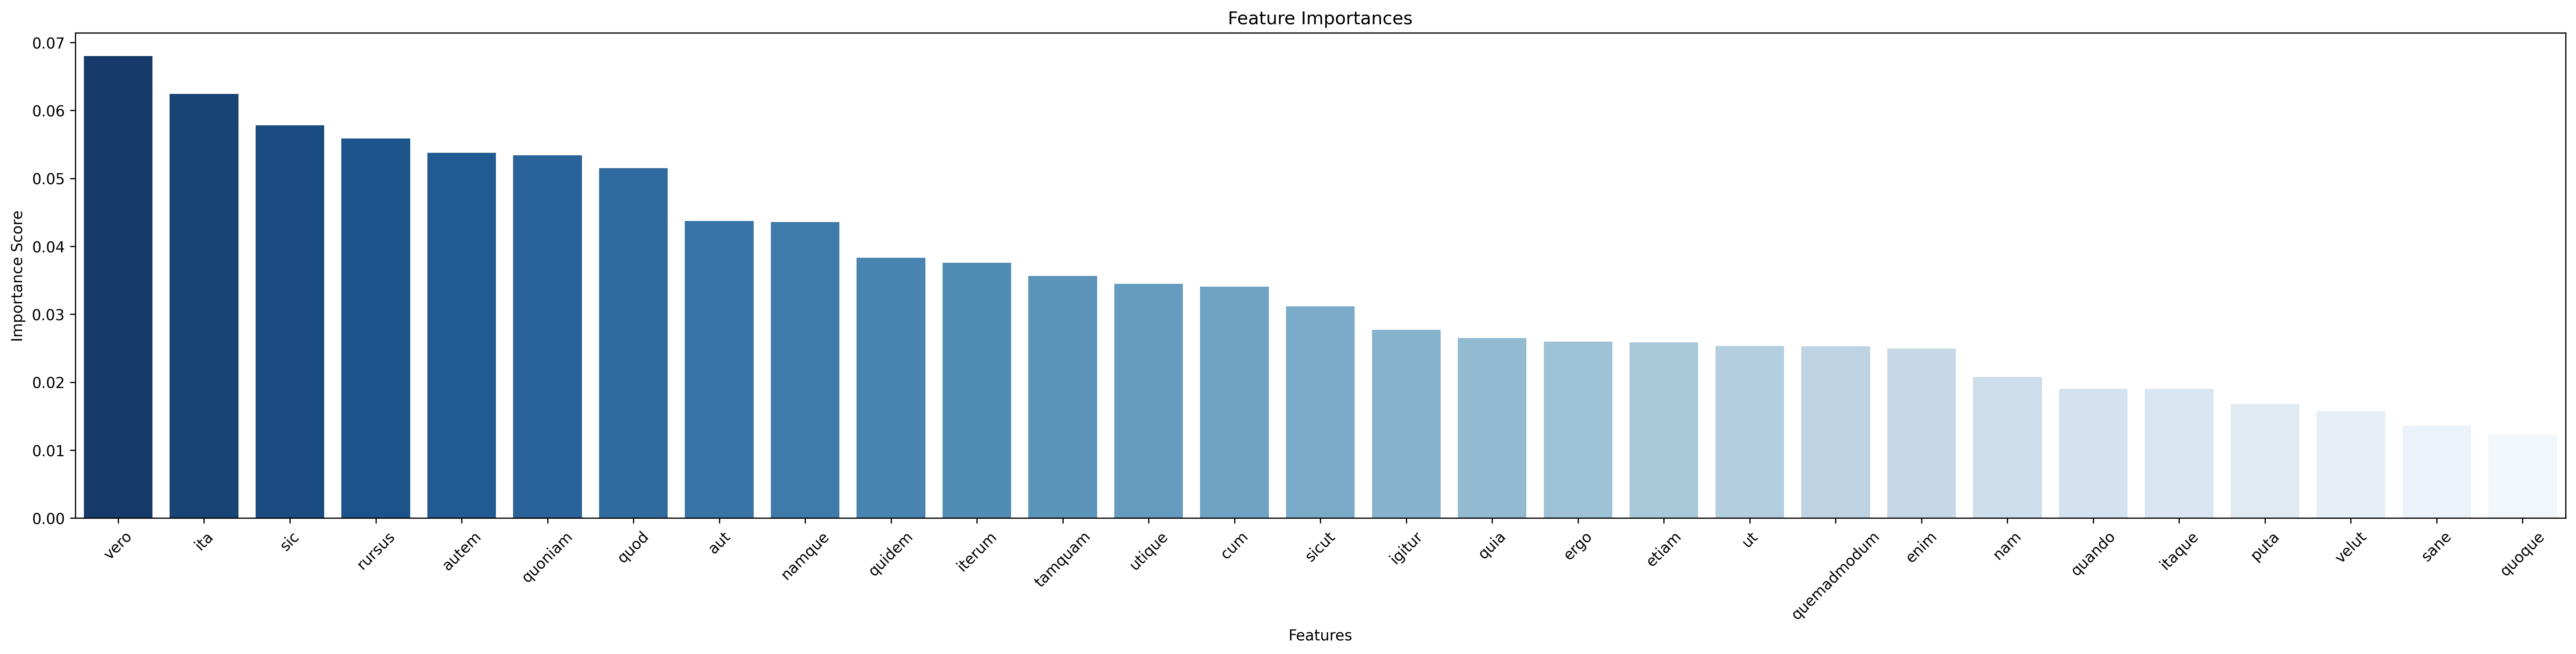

In [41]:
X = testing_df.drop(['Translator','Work','Chunk'], axis=1)
y = testing_df.Translator
rf.fit(X,y)

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
features = testing_df.columns[3:]
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(30,6),dpi=300)
sns.barplot(x=features[indices], y=importances[indices], palette='Blues_r')
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importances')
plt.show()

In [27]:
sample_size = min(samp_ctr.values()) // 2

feats = len(X.columns)
res = []
for i in range(2,feats+1,1):
    rf = RandomForestClassifier(n_estimators=1000,
                            max_features=i,
                            n_jobs=-1
                            )
    global_scores = []
    # each time, get a balanced sample, sized at half the minimum class count
    # which, for now, is 17 (Arist has 35 samples)
    for _ in range(10):
        samp = testing_df.groupby('Translator').apply(lambda x: x.sample(sample_size)).reset_index(drop=True)
        X = samp.drop(['Translator','Work','Chunk'], axis=1)
        y = samp.Translator
        scores = cross_val_score(rf, X, y, cv=5)
        global_scores.append(scores.mean())
    a = np.array(global_scores)
    res.append({'Feats':i, 'Acc': a.mean()})

res_df = pd.DataFrame(res)


<AxesSubplot:xlabel='Feats'>

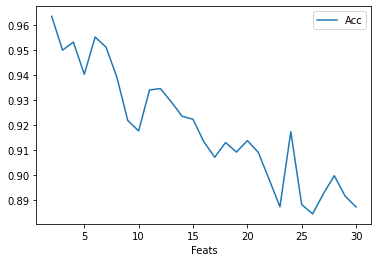

In [28]:
res_df.plot.line(x='Feats',y='Acc')

In [24]:
sample_size = min(samp_ctr.values()) // 2

res = []
for i in range(100,1150,50):
    rf = RandomForestClassifier(n_estimators=i,
                            max_features=0.05,
                            n_jobs=-1
                            )
    global_scores = []
    # each time, get a balanced sample, sized at half the minimum class count
    # which, for now, is 17 (Arist has 35 samples)
    for _ in range(20):
        samp = stops_tidy.groupby('Translator').apply(lambda x: x.sample(sample_size)).reset_index(drop=True)
        X = samp.drop(['Translator','Work','Chunk'], axis=1)
        y = samp.Translator
        scores = cross_val_score(rf, X, y, cv=5)
        global_scores.append(scores.mean())
    a = np.array(global_scores)
    res.append({'Estimators':i, 'Acc': a.mean()})

est_df = pd.DataFrame(res)


<AxesSubplot:xlabel='Estimators'>

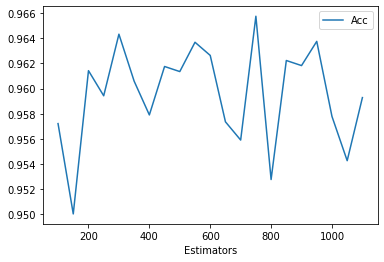

In [25]:
est_df.plot.line(y='Acc',x='Estimators')

In [26]:
plt.rcParams["figure.dpi"] = 144

In [83]:
X = testing_df.drop(['Translator','Work','Chunk'], axis=1)
y = testing_df.Translator
rf.fit(X,y)

RandomForestClassifier(max_features=0.05, n_estimators=500, n_jobs=-1)

In [79]:
myst_df = stops_tidy[stops_tidy.Translator == 'Myst']
myst_df

,Translator,Work,Chunk,aut,autem,cum,enim,ergo,etiam,igitur,...,quoque,rursus,sane,sic,sicut,tamquam,ut,utique,velut,vero
600,Myst,5,de eo autem quod est esse alia quidem longe ui...,0.059294,0.321884,0.008471,0.228707,0.000000,0.025412,0.042353,...,0.000000,0.000000,0.008471,0.042353,0.050824,0.000000,0.050824,0.067765,0.000000,0.059294
746,Myst,4,non est facile dignoscere quando oportet vinde...,0.000000,0.269222,0.075382,0.096920,0.000000,0.032307,0.010769,...,0.000000,0.010769,0.000000,0.010769,0.000000,0.000000,0.096920,0.000000,0.000000,0.107689
747,Myst,4,est vetus autem calidissimum et fortissimum et...,0.000000,0.278411,0.098791,0.080829,0.008981,0.008981,0.008981,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.080829,0.000000,0.000000,0.080829
767,Myst,1,consideranti mihi o syre angulorum acceptorum ...,0.000000,0.317775,0.027238,0.018159,0.000000,0.009079,0.009079,...,0.000000,0.000000,0.000000,0.000000,0.009079,0.000000,0.127110,0.000000,0.000000,0.000000
768,Myst,1,servant et vocant proprie horariam pro ipsa au...,0.026796,0.303693,0.000000,0.044661,0.017864,0.000000,0.053593,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.008932,0.053593,0.017864,0.000000,0.008932
769,Myst,1,que ek ab l autem super eh que mln super eg au...,0.000000,0.219615,0.037865,0.007573,0.007573,0.015146,0.037865,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022719,0.015146,0.000000,0.022719
770,Myst,1,in duo equa videlicet secans ipsam htk diametr...,0.000000,0.216794,0.015485,0.015485,0.015485,0.000000,0.046456,...,0.000000,0.000000,0.000000,0.007743,0.000000,0.000000,0.054198,0.015485,0.000000,0.000000
771,Myst,1,at s partes 23 dimidiam et tertiam ubi autem h...,0.000000,0.300105,0.050018,0.050018,0.000000,0.000000,0.030011,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.110039,0.000000,0.000000,0.020007
772,Myst,3,completivum ipsius existit quare et ipsum dist...,0.219694,0.261540,0.031385,0.198770,0.041846,0.052308,0.083693,...,0.031385,0.000000,0.000000,0.010462,0.073231,0.000000,0.041846,0.020923,0.000000,0.052308
773,Myst,3,ineptum consideratur que enim secundum proport...,0.043013,0.236573,0.107533,0.129040,0.021507,0.032260,0.043013,...,0.021507,0.000000,0.000000,0.010753,0.032260,0.000000,0.053767,0.021507,0.000000,0.010753


In [86]:
X = myst_df.drop(['Translator','Work','Chunk'],axis=1)

In [87]:
myst_df.insert(1, 'Predicted', rf.predict(X))

In [96]:
myst_df.groupby('Work')['Predicted'].apply(lambda x: Counter(x).items())

Work
1    ((Wil, 3), (Bur, 2))
2              ((Wil, 1))
3    ((Wil, 9), (Bur, 1))
4              ((Bur, 2))
5              ((Jam, 1))
Name: Predicted, dtype: object